In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot.plotting_utilities import *
import os
import sys
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True  # Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath}'
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
this_directory = os.getcwd() + "/"
this_filename = 'inter-node-traffic-reduction'
project_dir = this_directory + '../'

In [3]:
# Inputs
config = {
    'res_dir': project_dir + 'results/cpu/',
    'cases': ['lhc', 'sps', 'ps'],
    'outdir': project_dir + 'results/cpu/plots/',
    'x_label': 'N',
    'y_label': 'total_time(sec)',
    'colors': {
#         'exact-timing-cpu': '.8',
#         'float32-timing-cpu': '.8',
#         'f32-srp-timing-cpu': '.5',
#         'srp-timing-cpu': '.5',
#         'f32-rds-timing-cpu': '.3',
#         'rds-timing-cpu': '.3',
        'exact-timing-cpu': 'tab:orange',
        'float32-timing-cpu': 'tab:orange',
        'f32-srp-timing-cpu': 'tab:blue',
        'srp-timing-cpu': 'tab:blue',
        'f32-rds-timing-cpu': 'tab:green',
        'rds-timing-cpu': 'tab:green',

    },
    'hatches': {
        'exact-timing-cpu': '',
        'float32-timing-cpu': '///',
        'f32-srp-timing-cpu': '///',
        'srp-timing-cpu': '',
        'f32-rds-timing-cpu': '///',
        'rds-timing-cpu': '',
    },
    'labels': {
        'exact-timing-cpu': 'Base',
        'float32-timing-cpu': 'F32',
        'f32-srp-timing-cpu': 'F32-SRP',
        'srp-timing-cpu': 'SRP',
        'f32-rds-timing-cpu': 'F32-RDS',
        'rds-timing-cpu': 'RDS',
    },
}

In [4]:
plot_dir = {}
# case = 'lhc'
# version = 'rds-timing-cpu'
for case in config['cases']:
    plot_dir[case] = {}
    for version in ['exact-timing-cpu', 'float32-timing-cpu', 'srp-timing-cpu', 'f32-srp-timing-cpu', 'rds-timing-cpu', 'f32-rds-timing-cpu']:        
        file = f'{config["res_dir"]}/{case}/{version}/avg-report.csv'
        data = np.genfromtxt(file, delimiter='\t', dtype=str)
        header, data = list(data[0]), data[1:]
        # print(header)
        df = pd.DataFrame(data=data, columns=header)
        df = df.drop(["s", "t", "mtw", 'seed', 'mpi', 'lb', 'tp', 'artdel','gpu','std(%)', 'time_per_call(ms)'], axis=1)
        df = df.loc[df['function'].isin(['comm:allreduce', 'comm:gather', 'serial:sync'])]
        # print(df)
        df = df.loc[df['red'].isin(['1', '3'])]
        df = df.loc[df['N'] == '8']
        df = df.set_index(['ppb', 'b', 'n', 'N', 'omp', 'approx', 'prec'], drop=True)
#         df.loc[df['function'] == 'serial:sync'][config['y_label']]
        df = df.astype({config['y_label']: float})
        # print(df)
        if 'rds' not in version:
            df.loc[df['function'] == 'comm:gather', config['y_label']] += df.loc[df['function'] == 'serial:sync'][config['y_label']] + df.loc[df['function'] == 'comm:allreduce'][config['y_label']] 
        # print(df)
        df = df.loc[df['function'] == 'comm:gather']
        x = df.index.get_level_values(config['x_label']).values.astype(int)
        y = df[config['y_label']].values
        #         x, y
        plot_dir[case][version] = {
            'x': x,
            'y': y
        }

In [5]:
plot_dir

{'lhc': {'exact-timing-cpu': {'x': array([8]), 'y': array([242.46])},
  'float32-timing-cpu': {'x': array([8]), 'y': array([199.26])},
  'srp-timing-cpu': {'x': array([8]), 'y': array([94.66])},
  'f32-srp-timing-cpu': {'x': array([8]), 'y': array([77.16])},
  'rds-timing-cpu': {'x': array([8]), 'y': array([71.48])},
  'f32-rds-timing-cpu': {'x': array([8]), 'y': array([33.64])}},
 'sps': {'exact-timing-cpu': {'x': array([8]), 'y': array([253.4])},
  'float32-timing-cpu': {'x': array([8]), 'y': array([260.37])},
  'srp-timing-cpu': {'x': array([8]), 'y': array([104.26])},
  'f32-srp-timing-cpu': {'x': array([8]), 'y': array([85.26])},
  'rds-timing-cpu': {'x': array([8]), 'y': array([51.41])},
  'f32-rds-timing-cpu': {'x': array([8]), 'y': array([32.78])}},
 'ps': {'exact-timing-cpu': {'x': array([8]), 'y': array([182.85])},
  'float32-timing-cpu': {'x': array([8]), 'y': array([161.24])},
  'srp-timing-cpu': {'x': array([8]), 'y': array([132.31])},
  'f32-srp-timing-cpu': {'x': array([

/home/kiliakis/install/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to Helvetica.


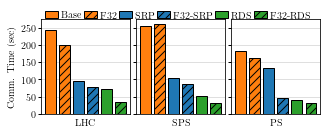

In [6]:
fig, ax_arr = plt.subplots(nrows=1, ncols=len(config['cases']), figsize=(5,1.5),
                          sharex=True, sharey=True)

labels = set()
for col, case in enumerate(config['cases']):
    ax = ax_arr[col]
    plt.sca(ax)
    pos = 0
    step = 1
    width = .85 * step / (len(plot_dir[case])-1)
    for version in plot_dir[case]:
        x = plot_dir[case][version]['x']
        y = plot_dir[case][version]['y']
        xpos = pos + np.arange(len(x))
        legend = config['labels'][version]
        if legend in labels:
            legend = None
        else:
            labels.add(legend)

        plt.bar(xpos, y, edgecolor='black', 
                width=0.75 * width, label=legend,
                color=config['colors'][version],
                hatch=config['hatches'][version])
        
        pos += width
        
    plt.grid(True, which='major', alpha=0.5)
    plt.grid(False, which='major', axis='x')
    plt.gca().set_axisbelow(True)
    if col == 0:
        plt.ylabel('Comm. Time (sec)')
        plt.legend(loc='upper left', ncol=6, handlelength=1.3, fancybox=True,
            framealpha=0, fontsize=10, labelspacing=0, borderpad=0.4,
            handletextpad=0.3, borderaxespad=0.1, columnspacing=0.25,
            bbox_to_anchor=(-0.01, 1.15)
            )

#     if col == 1:
    plt.xlabel(case.upper(), fontsize=10, labelpad=4)
    plt.xticks([], [])
    plt.yticks([0, 50, 100, 150, 200, 250])
#     plt.title(r'\bfseries ' + '{}'.format(case.upper()), fontsize=10, fontweight='bold', y=0.83)
    ax.tick_params(pad=2, top=0, bottom=1, left=1,
                     direction='out', length=3, width=1)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.07, hspace=0.1, top=1)

outfiles = [f'{config["outdir"]}/{this_filename}.pdf', f'{config["outdir"]}/{this_filename}.png']
for outfile in outfiles:
    save_and_crop(fig, outfile,dpi=600, bbox_inches='tight')

# nbins = 100
# count, x = np.histogram(s, nbins, density=True)
# # print(bins)
# y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
# plt.plot(x, y, linewidth=2, color='tab:blue')
# plt.plot(x[nbins//2 - 11:nbins//2+11], y[nbins//2 - 11:nbins//2+11], linewidth=2, color='tab:red')
# ax.fill_between(x[nbins//2 - 11:nbins//2+11], 0, y[nbins//2 - 11:nbins//2+11], alpha=0.2, facecolor='tab:red')
# plt.ylim(0)
# plt.xticks([])
# plt.yticks([])
# plt.xlabel('Bins', fontsize=11)
# plt.ylabel('Bin Count', fontsize=11)
# plt.annotate(r'\bfseries In Shared Mem', xy=(x[nbins//2+6], y[nbins//2+6]),
#             xycoords='data', xytext=(0.15, 3.7),
#             arrowprops={'facecolor':'tab:red', 'shrink':0.05},
#             color='tab:red', fontsize=11)
# plt.annotate(r'\bfseries In Global Mem', xy=(x[nbins//2-20], y[nbins//2-20]),
#             xycoords='data', xytext=(-0.4, 2.5),
#             arrowprops={'facecolor':'tab:blue', 'shrink':0.05},
#             color='tab:blue',fontsize=11,
#             ha='left')
# plt.annotate(r'\bfseries In Global Mem', xy=(x[nbins//2+18], y[nbins//2+18]),
#             xycoords='data', xytext=(0.4, 2.5),
#             arrowprops={'facecolor':'tab:blue', 'shrink':0.05},
#             color='tab:blue', ha='right', fontsize=11)
# plt.annotate(r'\bfseries Hot Bins', xy=(0, 2.5),
#             xycoords='data', ha='center', va='center',
#             color='black', fontsize=11)
# plt.tight_layout()
